In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [ ]:
!git config --global user.email "idantsri2007@gmail.com"
!git config --global user.name "SILETRO"

In [ ]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

In [ ]:
%cd /content/Cryptonite-RTP-Idant

/content/Cryptonite-RTP-Idant


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/FER_Transfer_Learning.ipynb' Task-4/

In [ ]:
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   Task-4/FER_Transfer_Learning.ipynb



In [ ]:
!git commit -m "Initial commit: Add notebook and files"
!git push -u origin main

[main 33fde89] Initial commit: Add notebook and files
 1 file changed, 1 insertion(+)
 create mode 100644 Task-4/FER_Transfer_Learning.ipynb
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 180.21 KiB | 6.44 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SILETRO/Cryptonite-RTP-Idant.git
   22ada38..33fde89  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [3]:
train_dir = path + "/train"
test_dir = path + "/test"

In [20]:
from IPython.testing import test
import tensorflow as tf


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(48,48),
    batch_size=64,
    color_mode='grayscale'
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(48,48),
    batch_size=64,
    color_mode='grayscale'
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(48,48),
    batch_size=64,
    shuffle=False,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


<Axes: ylabel='count'>

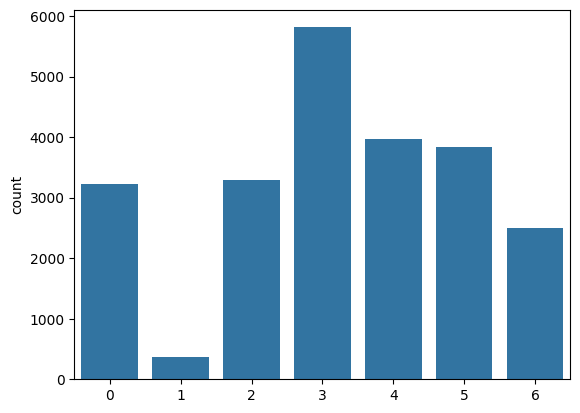

In [5]:
class_names = train_ds.class_names

train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)
sns.countplot(x=train_labels)

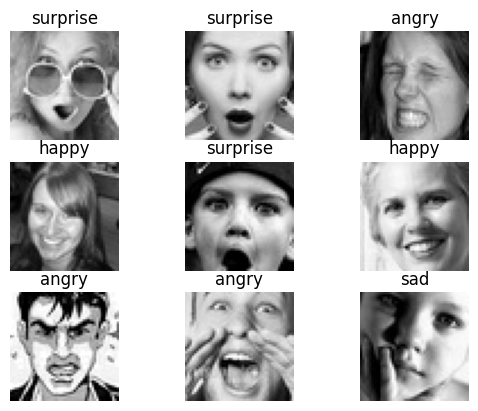

In [6]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")

        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
from sklearn.utils import class_weight
for _,label in train_ds:
    all_classes = np.concatenate([label],axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(7),
    y=all_classes
)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
class_weights_dict

{0: np.float64(2.0),
 1: np.float64(4.0),
 2: np.float64(0.8),
 3: np.float64(0.5333333333333333),
 4: np.float64(2.0),
 5: np.float64(0.6666666666666666),
 6: np.float64(0.8888888888888888)}

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',input_shape= (224,224,3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomRotation(0.05)
])

In [11]:
inputs = tf.keras.Input(shape=(48, 48, 1))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.layers.Concatenate()([x, x, x])
x= tf.keras.applications.efficientnet.preprocess_input(x)
x = data_augmentation(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

model_head = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax')
])
outputs = model_head(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='Adam',metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [13]:
history = model.fit(train_ds,epochs=10,class_weight=class_weights_dict,validation_data=val_ds)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - loss: 1.9614 - sparse_categorical_accuracy: 0.2471 - val_loss: 1.5002 - val_sparse_categorical_accuracy: 0.4391
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 170ms/step - loss: 1.7022 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.4353 - val_sparse_categorical_accuracy: 0.4569
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 163ms/step - loss: 1.6386 - sparse_categorical_accuracy: 0.3967 - val_loss: 1.4348 - val_sparse_categorical_accuracy: 0.4647
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - loss: 1.5856 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.4802
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step - loss: 1.5406 - sparse_categorical_accuracy: 0.4328 - val_loss: 1.3834 - val_sparse_categorical_accuracy: 0.4795
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - loss: 1.5244 - sparse_categorical_accuracy: 0.4347 - val_loss: 1.3516 - val_sparse_categorical_acc

In [14]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
  layer.trainable = False
for layer in base_model.layers[-50:]:
  if(not isinstance(layer,tf.keras.layers.BatchNormalization)):
    layer.trainable = True
  else:
    layer.trainable = False

inputs = tf.keras.Input(shape=(48, 48, 1))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.layers.Concatenate()([x, x, x])
x= tf.keras.applications.efficientnet.preprocess_input(x)
x = data_augmentation(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = model_head(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy])

In [15]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 2,508,688 (9.57 MB)

 Non-trainable params: 1,540,883 (5.88 MB)

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
model.fit(train_ds,epochs=50,initial_epoch=len(history.epoch),validation_data=val_ds,class_weight=class_weights_dict,callbacks=[early_stop])

Epoch 11/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - loss: 1.4128 - sparse_categorical_accuracy: 0.4820 - val_loss: 1.2163 - val_sparse_categorical_accuracy: 0.5294
Epoch 12/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.2847 - sparse_categorical_accuracy: 0.5294 - val_loss: 1.1880 - val_sparse_categorical_accuracy: 0.5476
Epoch 13/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 188ms/step - loss: 1.2351 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.1623 - val_sparse_categorical_accuracy: 0.5619
Epoch 14/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.5688 - val_loss: 1.0930 - val_sparse_categorical_accuracy: 0.5858
Epoch 15/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 186ms/step - loss: 1.1251 - sparse_categorical_accuracy: 0.5858 - val_loss: 1.1202 - val_sparse_categorical_accuracy: 0.5759
Epoch 16/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - loss: 1.0761 - sparse_categorical_accuracy: 0.5993 - val_loss: 1.1407 - val_sparse_categoric

In [17]:
model.evaluate(test_ds)

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 1.0783 - sparse_categorical_accuracy: 0.6042


[1.0692082643508911, 0.6069936156272888]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import numpy as np

all_test_labels_list = []
y_pred_probabilities_list = []

for images, labels in test_ds:
    all_test_labels_list.extend(labels.numpy())
    y_pred_probabilities_list.extend(model.predict_on_batch(images))

all_test_labels = np.array(all_test_labels_list)
y_pred = np.array(y_pred_probabilities_list)
y_pred_class = np.argmax(y_pred, axis=1)


Shape of all_test_labels: (7178,)
Shape of y_pred_class: (7178,)


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# 2. Get predictions (probabilities)
# Ensure shuffle=False was used when creating test_ds to keep order consistent
predictions = model.predict(test_ds)

# 3. Convert probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step


In [22]:
# Get the class names from the dataset object
target_names = test_ds.class_names

# Generate the report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       angry       0.46      0.65      0.54       958
     disgust       0.42      0.63      0.50       111
        fear       0.52      0.25      0.34      1024
       happy       0.84      0.84      0.84      1774
     neutral       0.49      0.77      0.60      1233
         sad       0.58      0.26      0.36      1247
    surprise       0.72      0.78      0.75       831

    accuracy                           0.61      7178
   macro avg       0.58      0.60      0.56      7178
weighted avg       0.62      0.61      0.59      7178



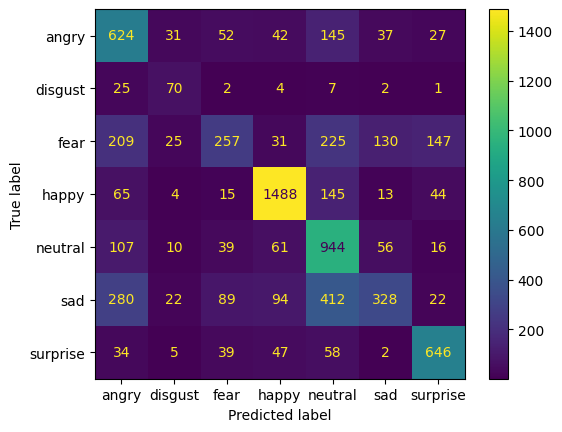

In [23]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()